# Can we predict the who would've survived the Titanic?

## Step 1: Get the data ready

Download the data from the site: https://www.kaggle.com/c/titanic/data

## Step 2: Make the workplace ready

Import all the necessary dependencies

In [90]:
# Import Dependencies
%matplotlib inline

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
plt.style.use('seaborn-whitegrid')

# Preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine Learning
import catboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, model_selection, tree, preprocessing, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier    
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv


## Loading in the data
Get the data in the notebook

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
gender_submission = pd.read_csv('data/gender_submission.csv')

In [3]:
# View the training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# View the test data (labels same as training data)
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# View the sample submission dataframe
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Data Description

**Survived:** 0 = No, 1 = Yes

**Pclass:** 1 = 1st, 2 = 2nd, 3 = 3rd 

**Sex:** Gender

**Age:** Age in years

**SibSp:** Number of siblings/spouces aboard the Titanic

**Parch:** Number of parents/children aboard the Titanic

**Ticket:** Ticket number

**Fare:** Passender fare

**Cabin:** Cabin number

**Embarked:** Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


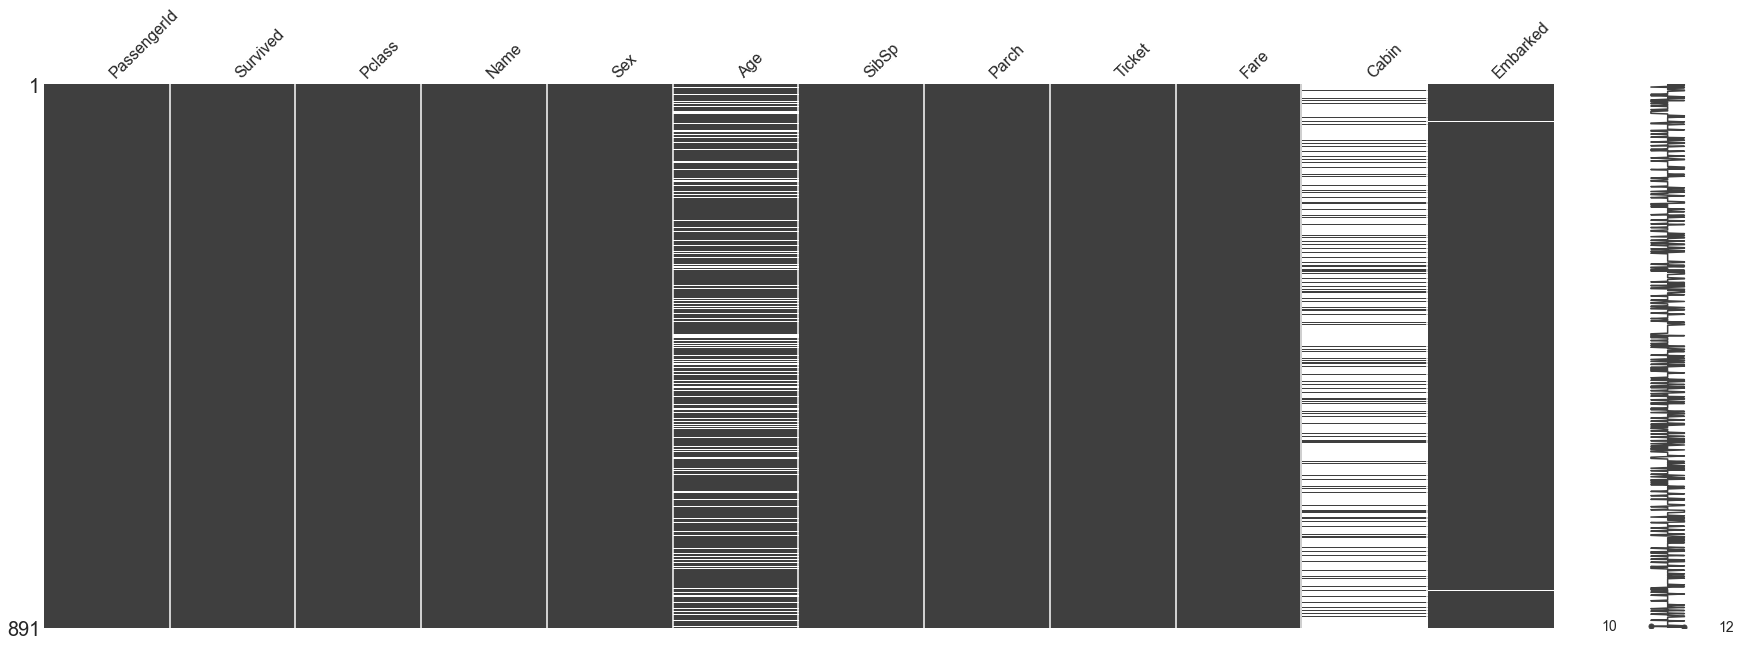

In [10]:
# Check the missing values and visualize
missingno.matrix(train, figsize=(30,10)); # (width, height);

In [11]:
# Find the sum of all the missing values of the columns
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## To perform our data analysis, let's create two dataframes

In [12]:
df_bin = pd.DataFrame() # for discritised continous variable
df_con = pd.DataFrame() # for continuous variables

In [13]:
# What datatypes are the in main dataframe?
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## Let's explore each of these features individually

In [14]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Target Feature: Survived

**Description:** Whether the passenger survived or not.

**Key:** 0 = did not survive, 1 = survived

0    549
1    342
Name: Survived, dtype: int64


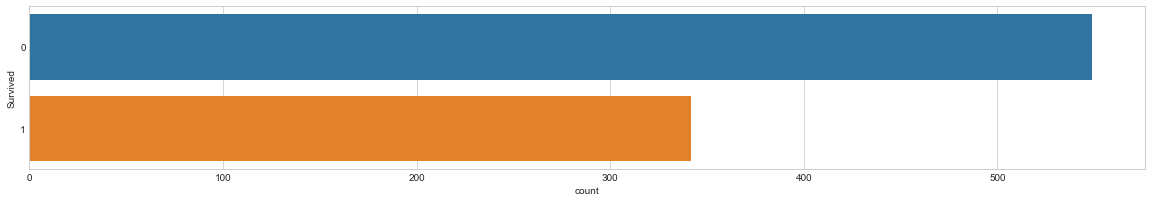

In [15]:
# How many people survived??
fig = plt.figure(figsize=(20, 3))
sns.countplot(y='Survived', data=train)
print(train.Survived.value_counts())

In [16]:
# Let's add this column to our subset dataframes
df_bin['Survived'] = train.Survived
df_con['Survived'] = train.Survived

### Feature: Pclass

**Description:** The ticket class of the passenger.

**Key:** 1 = 1st, 2 = 2nd, 3 = 3rd

#### Let's plot the distribution to understand what kind of spread there is across the model.

C:\Users\amitt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


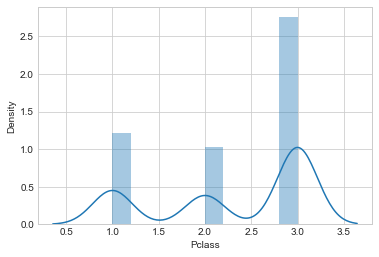

In [17]:
sns.distplot(train.Pclass); # Also helps to remove the outliers

In [18]:
# How many missing values are there in Pclass?
train.Pclass.isna().sum()

0

In [19]:
# Since there are no missing values, add this to our sub dataframes
df_bin['Pclass'] = train.Pclass
df_con['Pclass'] = train.Pclass

### Feature: Name

**Description:** The name of the passenger.


In [20]:
# How many different values are there?
train.Name.value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

### Feature: Sex

**Description:** The gender of the passenger.

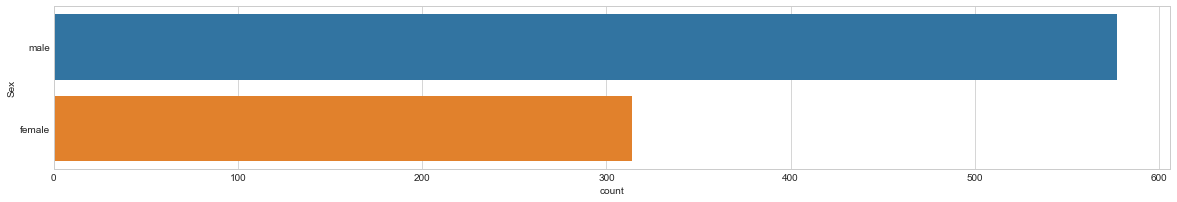

In [21]:
# Let's view the distribution of Sex
plt.figure(figsize=(20,3))
sns.countplot(y=train.Sex);

In [22]:
# Are there any missing values in sex column
train.Sex.isna().sum()

0

Since this is already binary variable (male or female). Let's add it to our subset dataframes

In [23]:
# Add Sex to the subset dataframes
df_bin['Sex'] = train.Sex
df_bin.Sex = np.where(df_bin.Sex == 'female', 1, 0)

df_con['Sex'] = train.Sex

C:\Users\amitt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\amitt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


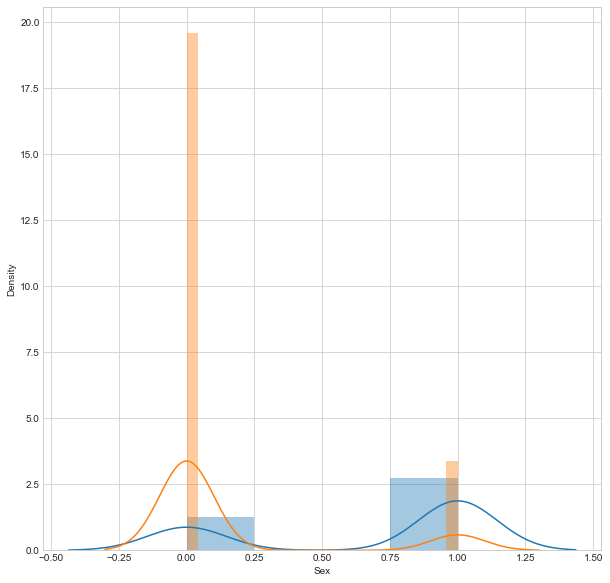

In [24]:
# How does the Sex variable look compared to Survival?
# We can plot this because they're both binary
fig = plt.figure(figsize=(10, 10))
sns.distplot(df_bin.loc[df_bin.Survived == 1]['Sex'], kde_kws={'label': 'Survived'})
sns.distplot(df_bin.loc[df_bin.Survived == 0]['Sex'], kde_kws={'label': 'Did not survive'});

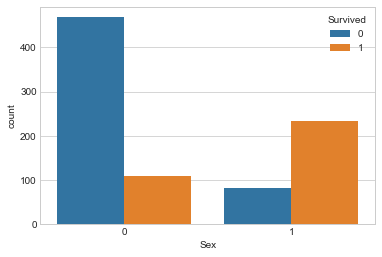

In [25]:
# OR
sns.countplot(x='Sex', hue='Survived', data=df_bin);

Not many people survived. But of those who did, more were female. 

### Feature: Age

**Description:** The age of the passenger.

In [26]:
# How many missing values Age column has?
train.Age.isna().sum()

177

In [27]:
# Fill the missing values of Age columns using interpolate() method
train.Age.interpolate(method='linear', axis=0, inplace=True)

In [28]:
# Check again how many missing values are there...
train.Age.isna().sum()

0

In [29]:
# Since there are 0 missing values in Age column now, let's add to our sub dataframes
df_bin['Age'] = pd.cut(train.Age, 10) # bucketed/binned into different categories
df_con['Age'] = train.Age # non-bucketed

Function to create count and distribution visualisation

In [30]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20,5), use_bin_df=False):
    '''
    Function to plot counts and distributions of a label variable and 
    target variable side by side.

    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    '''

    if use_bin_df:
        fig = plt.figure(figsize=figsize)

        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df)

        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], kde_kws={'label': 'Survived'})
        sns.distplot(data.loc[data[label_column] == 0][target_column], kde_kws={'label': 'Did not survive'});

    else:
        fig = plt.figure(figsize=figsize)

        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data)

        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], kde_kws={'label': 'Survived'})
        sns.distplot(data.loc[data[label_column] == 0][target_column], kde_kws={'label': 'Did not survive'});

    plt.legend()

### Feature: Age

**Description:** The number of siblings/spouces the passesnger has aboard the Titanic.

In [31]:
# How many missing values does Sibsp have?
train.SibSp.isna().sum()

0

In [32]:
# How many type of values are there?
train.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [33]:
# Let's add this column to our subset
df_bin['SibSp'] = train.SibSp
df_con['SibSp'] = train.SibSp

In [34]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,22.5,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


C:\Users\amitt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\amitt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


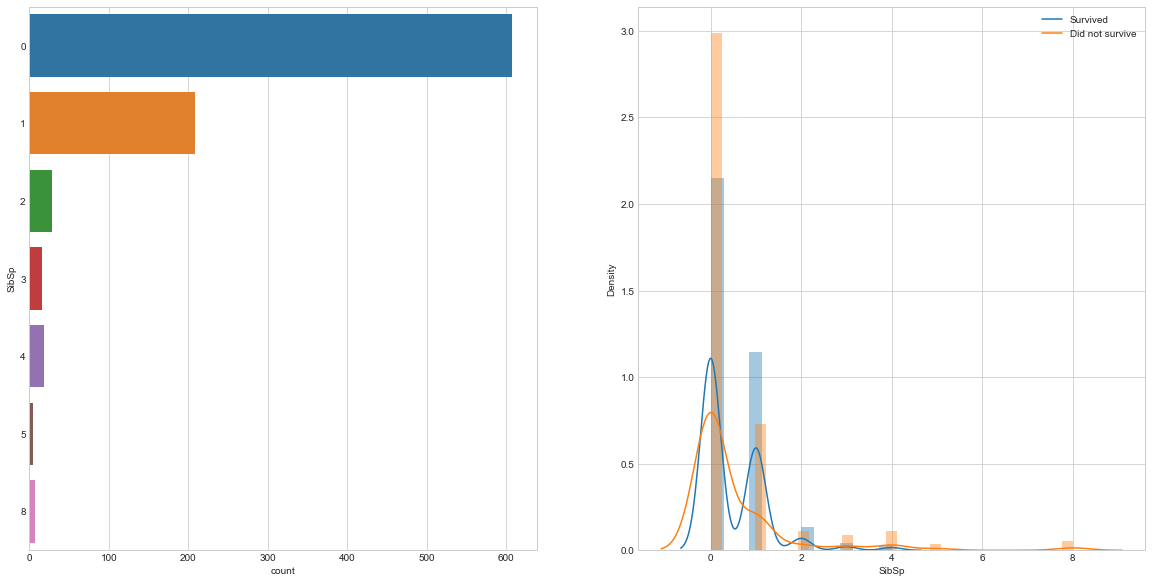

In [35]:
# Visualize the counts of SibSp and the distribution of the values against Survived
plot_count_dist(data=train, bin_df=df_bin, label_column='Survived', target_column='SibSp', figsize=(20, 10))


### Feature: Parch

**Description:** The number of parents/children the passesnger has aboard the Titanic.

In [36]:
# How many missing values are there?
train.Parch.isna().sum()

0

In [37]:
# Add Parch to subset dataframes
df_bin['Parch'] = train.Parch
df_con['Parch'] = train.Parch

C:\Users\amitt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\amitt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


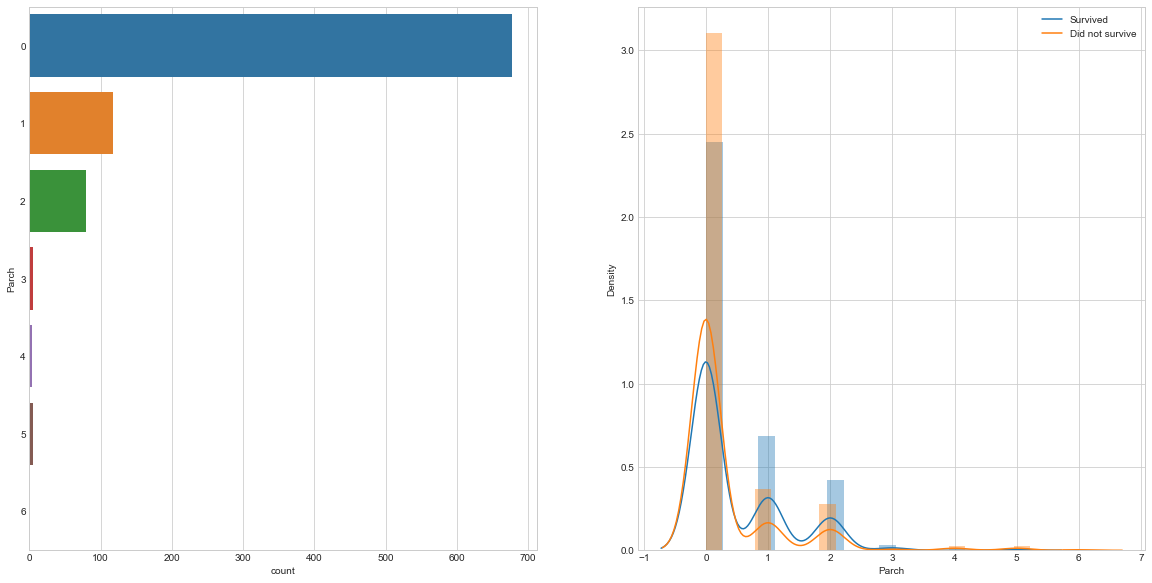

In [38]:
# Visualize the contents of Parch and the distribution of the values against Survived
plot_count_dist(data=train, bin_df=df_bin, label_column='Survived', target_column='Parch', figsize=(20, 10))

In [39]:
df_con.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,male,22.0,1,0
1,1,1,female,38.0,1,0
2,1,3,female,26.0,0,0
3,1,1,female,35.0,1,0
4,0,3,male,35.0,0,0


In [40]:
df_bin.head()

,Survived,Pclass,Sex,Age,SibSp,Parch
0,0,3,0,"(16.336, 24.294]",1,0
1,1,1,1,"(32.252, 40.21]",1,0
2,1,3,1,"(24.294, 32.252]",0,0
3,1,1,1,"(32.252, 40.21]",1,0
4,0,3,0,"(32.252, 40.21]",0,0


### Feature: Ticket

**Description:** The ticket number of the boarding passenger.

In [41]:
# How many missing values are there?
train.Ticket.isna().sum()

0

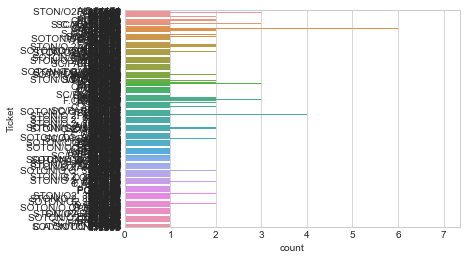

In [42]:
# How many kinds of ticket are there?
sns.countplot(y=train.Ticket);

The above graph doesn't look good...

In [43]:
# How many kinds of ticket are there?
train.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

Since there are 681 unique values which are too many. So, we won't use `Ticket` in our subset dataframe.

### Feature: Fare

**Description:** How much the ticket cost.

In [44]:
# How many missing values are there?
train.Fare.isna().sum()

0

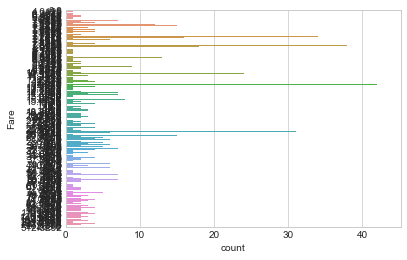

In [45]:
# How many different values of Fare are there?
sns.countplot(y=train.Fare);

In [46]:
# How many different values of Fare are there?
train.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
35.0000     1
28.5000     1
6.2375      1
14.0000     1
10.5167     1
Name: Fare, Length: 248, dtype: int64

As fare as 248 values and has a float64 dtype, let's add it our continous sub dataframe but to add it to our categorical sub dataframe, we'll cut it into bins.

In [47]:
# Add Fare to sub dataframes
df_bin['Fare'] = pd.cut(train.Fare, bins=5) # discretised 
df_con['Fare'] = train.Fare   

In [48]:
df_bin.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,"(16.336, 24.294]",1,0,"(-0.512, 102.466]"
1,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]"
2,1,3,1,"(24.294, 32.252]",0,0,"(-0.512, 102.466]"
3,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]"
4,0,3,0,"(32.252, 40.21]",0,0,"(-0.512, 102.466]"


In [49]:
df_con.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500


C:\Users\amitt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\amitt\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


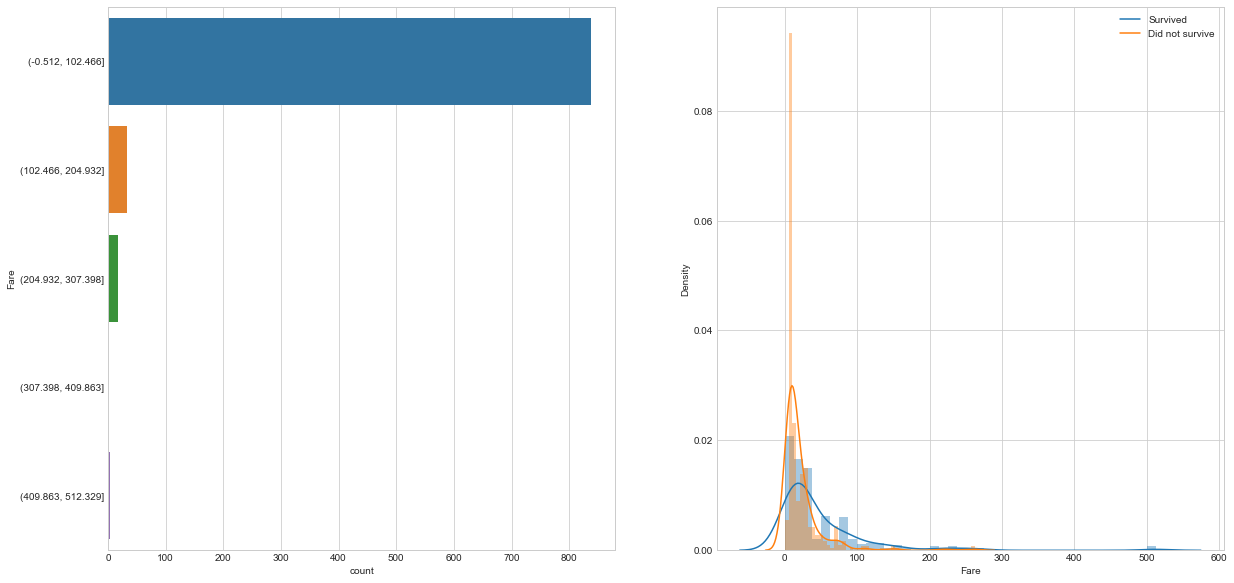

In [50]:
# Visualise the Fare bin counts as well as the Fare distribution versus Survived
plot_count_dist(data=train, bin_df=df_bin, label_column='Survived', target_column='Fare', figsize=(20, 10), use_bin_df=True)

### Feature: Cabin

**Description:** The cabin number where the passenger was staying.

In [51]:
# How many missing values are there?
train.Cabin.isna().sum()

687

In [52]:
# What do the cabin values look like?
train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

Since there are too many missing values, we won't use Cabin for our initial models and won't add it to our sub dataframes.

### Feature: Embarked

**Description:** The port where the passenger boarded the Titanic.

**Keys:** C = Cherbourg, Q = Queenstown, S = Southampton

In [53]:
# How many missing values does Embarked have?
train.Embarked.isna().sum()

2

In [54]:
# What kind of unique values are there in Embarked?
train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

Embarked is a categorical variable because there are 3 categories which a passenger could have boarded on

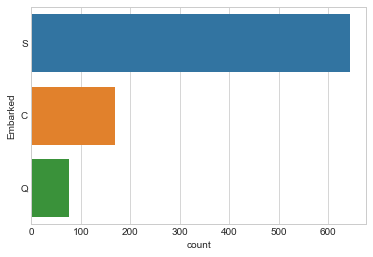

In [55]:
# What do the counts look like?
sns.countplot(y=train.Embarked);

In [56]:
# Add embarked to our sub dataframes
df_bin['Embarked'] = train.Embarked
df_con['Embarked'] = train.Embarked

In [57]:
# Remove Embarked rows which are having missing values
print(df_con.shape, df_bin.shape)
df_con.dropna(subset=['Embarked'], inplace=True, axis=0)
df_bin.dropna(subset=['Embarked'], inplace=True, axis=0)
print(df_con.shape, df_bin.shape)

(891, 8) (891, 8)
(889, 8) (889, 8)


## Feature Encoding

Encode our binned dataframe (`df_bin`) and our continous dataframe (`df_con`) with one-hot encoding.

In [58]:
df_bin.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,"(16.336, 24.294]",1,0,"(-0.512, 102.466]",S
1,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]",C
2,1,3,1,"(24.294, 32.252]",0,0,"(-0.512, 102.466]",S
3,1,1,1,"(32.252, 40.21]",1,0,"(-0.512, 102.466]",S
4,0,3,0,"(32.252, 40.21]",0,0,"(-0.512, 102.466]",S


In [59]:
# One-hot encode binned variables

## Get the list of all the columns
cols = df_bin.columns.to_list()

## Remove the target column from df_bin from the cols list
cols.remove('Survived')

## Use pd.get_dummies to one-hot ecode the dataframe
df_bin_enc = pd.get_dummies(data=df_bin, columns=cols)

## View the first 5 rows of the ecoded dataframe
df_bin_enc.head()

,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,"Age_(0.34, 8.378]","Age_(8.378, 16.336]","Age_(16.336, 24.294]","Age_(24.294, 32.252]",...,Parch_5,Parch_6,"Fare_(-0.512, 102.466]","Fare_(102.466, 204.932]","Fare_(204.932, 307.398]","Fare_(307.398, 409.863]","Fare_(409.863, 512.329]",Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,1,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,1,0,0,1,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
4,0,0,0,1,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [60]:
df_con.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [61]:
# One-hot encode categorical variables

df_embarked_onehot = pd.get_dummies(data=df_con.Embarked, prefix='embarked')
df_sex_onehot = pd.get_dummies(data=df_con.Sex, prefix='sex')
df_pclass_onehot = pd.get_dummies(data=df_con.Pclass, prefix='pclass')

In [62]:
# Combine the one-hot encoded columns with df_con_enc
df_con_enc = pd.concat([df_con, df_embarked_onehot, df_sex_onehot, df_pclass_onehot], axis=1)

# Drop the original categorical columns 
df_con_enc.drop(['Embarked', 'Sex', 'Pclass'], axis=1, inplace=True)

In [63]:
df_con_enc.head()

,Survived,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


## Start building machine learning models

### Let's separate the data

In [64]:
# Select the dataframe that we want to select
selected_df = df_con_enc

In [65]:
selected_df

,Survived,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,0,0,1,1,0,1,0,0
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,0,0,1,0,1,0,1,0
887,1,19.0,0,0,30.0000,0,0,1,1,0,1,0,0
888,0,22.5,1,2,23.4500,0,0,1,1,0,0,0,1
889,1,26.0,0,0,30.0000,1,0,0,0,1,1,0,0


In [66]:
# Split the dataframe into data and labels
X_train = selected_df.drop('Survived', axis=1) # data
y_train = selected_df.Survived # labels

In [67]:
X_train.shape, y_train.shape

((889, 12), (889,))

### Define a function to fit machine learning algorithms

In [68]:
def fit_ml_algo(algo, X_train, y_train, cv):
    '''
    Fit the model in anytype of Sci-kit Learn algorithm by fitting training data on it
    '''

    # One pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train)*100, 2)

    # Cross Validated Predictions
    train_pred = model_selection.cross_val_predict(estimator=algo, X=X_train, y=y_train, cv=cv, n_jobs=-1)

    # Cross Validated Accuracy Metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred)*100, 2)

    return train_pred, acc, acc_cv

In [69]:
%%time
# Logistic Regression 
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(algo=LogisticRegression(max_iter=248), X_train=X_train, y_train=y_train, cv=10)

print(f'Accuracy: {acc_log}')
print(f'Accuracy CV 10-Fold: {acc_cv_log}')

Accuracy: 79.98
Accuracy CV 10-Fold: 79.53
Wall time: 3.07 s


In [70]:
%%time
# K-Nearest Neighbours
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), X_train=X_train, y_train=y_train, cv=10)

print(f'Accuracy: {acc_knn}')
print(f'Accuracy CV 10-Fold: {acc_cv_knn}')

Accuracy: 80.31
Accuracy CV 10-Fold: 71.43
Wall time: 168 ms


In [71]:
%%time
# Gaussian Naive Bayes
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), X_train=X_train, y_train=y_train, cv=10)

print(f'Accuracy: {acc_gaussian}')
print(f'Accuracy CV 10-Fold: {acc_cv_gaussian}')

Accuracy: 78.74
Accuracy CV 10-Fold: 78.29
Wall time: 31 ms


In [72]:
%%time
# Linear SVC
train_pred_svc, acc_svc, acc_cv_svc = fit_ml_algo(LinearSVC(max_iter=10000000), X_train=X_train, y_train=y_train, cv=10)

print(f'Accuracy: {acc_svc}')
print(f'Accuracy CV 10-Fold: {acc_cv_svc}')

Accuracy: 79.98
Accuracy CV 10-Fold: 78.74
Wall time: 6min 39s


In [73]:
%%time
# Stochastic Gradient Descent
train_pred_sgd, acc_sgd, acc_cv_sgd = fit_ml_algo(SGDClassifier(), X_train=X_train, y_train=y_train, cv=10)

print(f'Accuracy: {acc_sgd}')
print(f'Accuracy CV 10-Fold: {acc_cv_sgd}')

Accuracy: 69.85
Accuracy CV 10-Fold: 68.39
Wall time: 89.3 ms


In [74]:
%%time
# Decision Tree Classifier
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), X_train=X_train, y_train=y_train, cv=10)

print(f'Accuracy: {acc_dt}')
print(f'Accuracy CV 10-Fold: {acc_cv_dt}')

Accuracy: 98.88
Accuracy CV 10-Fold: 77.62
Wall time: 73.8 ms


In [75]:
%%time
# Gradient Boosting Trees
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(), X_train=X_train, y_train=y_train, cv=10)

print(f'Accuracy: {acc_gbt}')
print(f'Accuracy CV 10-Fold: {acc_cv_gbt}')

Accuracy: 89.09
Accuracy CV 10-Fold: 82.68
Wall time: 419 ms


In [76]:
%%time
# Random Forest Classifier
train_pred_clf, acc_clf, acc_cv_clf = fit_ml_algo(RandomForestClassifier(), X_train=X_train, y_train=y_train, cv=10)

print(f'Accuracy: {acc_clf}')
print(f'Accuracy CV 10-Fold: {acc_cv_clf}')

Accuracy: 98.88
Accuracy CV 10-Fold: 79.98
Wall time: 630 ms


### Catboost Algorithm

It is state of that art open source gradient boosting on decision tree library.


In [77]:
# View the data for the CatBoost model
X_train.head()

,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,35.0,1,0,53.1000,0,0,1,1,0,1,0,0
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [78]:
# View the labels for the CatBoost model
y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [79]:
X_train.dtypes

Age           float64
SibSp           int64
Parch           int64
Fare          float64
embarked_C      uint8
embarked_Q      uint8
embarked_S      uint8
sex_female      uint8
sex_male        uint8
pclass_1        uint8
pclass_2        uint8
pclass_3        uint8
dtype: object

In [80]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float64)[0]
cat_features

array([ 1,  2,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int64)

This means CatBoost has picked up all the variables except the `Fare` and `Age` as they are not categorical variables

In [81]:
# Use the CatBoost Pool() function to pool together the training data and categorical features
train_pool = Pool(X_train, y_train, cat_features)

In [82]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000, custom_loss=['Accuracy'], loss_function='Logloss')

# Fit the CatBoost model
catboost_model.fit(train_pool, plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train)*100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.009797
0:	learn: 0.6867673	total: 172ms	remaining: 2m 51s
1:	learn: 0.6801380	total: 185ms	remaining: 1m 32s
2:	learn: 0.6745978	total: 194ms	remaining: 1m 4s
3:	learn: 0.6685554	total: 208ms	remaining: 51.8s
4:	learn: 0.6622903	total: 222ms	remaining: 44.3s
5:	learn: 0.6560304	total: 236ms	remaining: 39.1s
6:	learn: 0.6519913	total: 250ms	remaining: 35.5s
7:	learn: 0.6464996	total: 264ms	remaining: 32.8s
8:	learn: 0.6411472	total: 278ms	remaining: 30.6s
9:	learn: 0.6375778	total: 288ms	remaining: 28.5s
10:	learn: 0.6325163	total: 301ms	remaining: 27.1s
11:	learn: 0.6278199	total: 316ms	remaining: 26s
12:	learn: 0.6229640	total: 329ms	remaining: 25s
13:	learn: 0.6192489	total: 342ms	remaining: 24.1s
14:	learn: 0.6144156	total: 356ms	remaining: 23.4s
15:	learn: 0.6105431	total: 369ms	remaining: 22.7s
16:	learn: 0.6066263	total: 378ms	remaining: 21.9s
17:	learn: 0.6029313	total: 394ms	remaining: 21.5s
18:	learn: 0.5989528	total: 409ms	remaining: 21.1s
19:	learn: 0.

### CatBoost Cross Validation

In [83]:
%%time

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(pool=train_pool, params=cv_params, fold_count=10, plot=True)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6741548	test: 0.6746529	best: 0.6746529 (0)
1:	learn: 0.6595825	test: 0.6604592	best: 0.6604592 (1)
2:	learn: 0.6441686	test: 0.6458429	best: 0.6458429 (2)
3:	learn: 0.6287584	test: 0.6317850	best: 0.6317850 (3)
4:	learn: 0.6129247	test: 0.6170577	best: 0.6170577 (4)
5:	learn: 0.5994018	test: 0.6049452	best: 0.6049452 (5)
6:	learn: 0.5873047	test: 0.5933627	best: 0.5933627 (6)
7:	learn: 0.5766397	test: 0.5839002	best: 0.5839002 (7)
8:	learn: 0.5665091	test: 0.5744281	best: 0.5744281 (8)
9:	learn: 0.5565527	test: 0.5653219	best: 0.5653219 (9)
10:	learn: 0.5471705	test: 0.5568422	best: 0.5568422 (10)
11:	learn: 0.5399313	test: 0.5496602	best: 0.5496602 (11)
12:	learn: 0.5327315	test: 0.5430634	best: 0.5430634 (12)
13:	learn: 0.5245415	test: 0.5358077	best: 0.5358077 (13)
14:	learn: 0.5177415	test: 0.5296631	best: 0.5296631 (14)
15:	learn: 0.5106036	test: 0.5233618	best: 0.5233618 (15)
16:	learn: 0.5047103	test: 0.5179672	best: 0.5179672 (16)
17:	learn: 0.4988873	test: 0.51303

In [84]:
# Print out the CatBoost model metrics
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))

---CatBoost Metrics---
Accuracy: 86.28
Accuracy cross-validation 10-Fold: 83.34


## Model Results

Which model had the best cross-validated accuracy?

### Regular Accuracy Scores

In [85]:
model_scores = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Gaussian Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [acc_knn, acc_log, acc_gaussian, acc_sgd, acc_svc, acc_dt, acc_gbt, acc_catboost]
})

print('---Regular Accuracy Score---')
model_scores.sort_values(by='Score', ascending=False)

---Regular Accuracy Score---


,Model,Score
5,Decision Tree,98.88
6,Gradient Boosting Trees,89.09
7,CatBoost,86.28
0,KNN,80.31
1,Logistic Regression,79.98
4,Linear SVC,79.98
2,Gaussian Naive Bayes,78.74
3,Stochastic Gradient Decent,69.85


### Cross Validated Model Scores

In [86]:
cv_model_scores = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Gaussian Naive Bayes', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree', 'Gradient Boosting Trees',
              'CatBoost'],
    'Score': [acc_cv_knn, acc_cv_log, acc_cv_gaussian, acc_cv_sgd, acc_cv_svc, acc_cv_dt, acc_cv_gbt, acc_cv_catboost]
})

print('---Cross-Validation Accuracy Scores---')
cv_model_scores.sort_values(by='Score', ascending=False)

---Cross-Validation Accuracy Scores---


,Model,Score
7,CatBoost,83.34
6,Gradient Boosting Trees,82.68
1,Logistic Regression,79.53
4,Linear SVC,78.74
2,Gaussian Naive Bayes,78.29
5,Decision Tree,77.62
0,KNN,71.43
3,Stochastic Gradient Decent,68.39


Cross-validation is more robust than just the .fit() models as it does multiple passes over the data instead of one.

Because the CatBoost model got the best results, we'll use it for the next steps.

### Find the best parameters using Grid-Search for the CatBoostClassifier()

In [100]:
%%time
# Set params dictionary
params = {
    'depth'         : [4,5,6,7,8,9, 10],
    'learning_rate' : [0.01,0.02,0.03,0.04],
    'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
}

# Apply Grid-Search CV to to the CatBoostClassifier()
gs_catboost = GridSearchCV(estimator=CatBoostClassifier(iterations=1000, loss_function='Logloss'),
                        param_grid=params, 
                        cv=10,
                        n_jobs=-1)

Wall time: 0 ns


In [102]:
# Get the best parameters
gs_catboost.best_params_

{'depth': 5, 'iterations': 80, 'learning_rate': 0.04}

In [101]:
# Fit the training set to GridSearchCV model 
gs_catboost.fit(X_train, y_train)

0:	learn: 0.6777010	total: 1.16ms	remaining: 91.8ms
1:	learn: 0.6638492	total: 2.61ms	remaining: 102ms
2:	learn: 0.6506373	total: 4.3ms	remaining: 110ms
3:	learn: 0.6382734	total: 6.01ms	remaining: 114ms
4:	learn: 0.6264938	total: 7.28ms	remaining: 109ms
5:	learn: 0.6152128	total: 8.61ms	remaining: 106ms
6:	learn: 0.6060874	total: 10.4ms	remaining: 109ms
7:	learn: 0.5955168	total: 11.8ms	remaining: 106ms
8:	learn: 0.5864729	total: 13.2ms	remaining: 104ms
9:	learn: 0.5770563	total: 14.4ms	remaining: 101ms
10:	learn: 0.5689009	total: 15.7ms	remaining: 98.7ms
11:	learn: 0.5612552	total: 17ms	remaining: 96.2ms
12:	learn: 0.5540630	total: 18.2ms	remaining: 94.1ms
13:	learn: 0.5468128	total: 19.4ms	remaining: 91.6ms
14:	learn: 0.5408894	total: 21.2ms	remaining: 91.9ms
15:	learn: 0.5351980	total: 23ms	remaining: 91.9ms
16:	learn: 0.5295826	total: 24.4ms	remaining: 90.3ms
17:	learn: 0.5233368	total: 25.5ms	remaining: 87.8ms
18:	learn: 0.5174461	total: 26.6ms	remaining: 85.5ms
19:	learn: 0.5116

GridSearchCV(cv=10,
             estimator=<catboost.core.CatBoostClassifier object at 0x000001D1F66CC880>,
             n_jobs=-1,
             param_grid={'depth': [4, 5, 6, 7, 8, 9, 10],
                         'iterations': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                        100],
                         'learning_rate': [0.01, 0.02, 0.03, 0.04]})

In [105]:
# Using score() function find the accuracy
gs_catboost_score = gs_catboost.score(X_train, y_train)
gs_catboost_score

0.8335208098987626

## Feature Importance

Which features of the best model were most important for making predictions?

In [167]:
# Define a function for Feature Importance
def feature_importance(model, data):
    '''
    Function to show which features are most important in the model.
    model: Which model to use?
    data: What data to use?
    '''
    # Create a dataframe for feature importances
    fea_imp = pd.DataFrame({
        'Importance': model.feature_importances_,
        'Column': data.columns
    })

    # Sort the values
    fea_imp = fea_imp.sort_values(['Importance', 'Column'], ascending=[True, False]).iloc[-30:]

    # Draw a horizontal bar graph to visualize the dataframe
    plt.rcParams.update({'font.size': 14})
    plt.figure(figsize=(20,10))
    plt.barh(fea_imp.Column, fea_imp.Importance)
    plt.savefig('catboost-feature-importance.png')
    
    return fea_imp

,Importance,Column
5,0.653164,embarked_Q
4,0.847448,embarked_C
6,1.874170,embarked_S
10,1.920609,pclass_2
9,3.456038,pclass_1
11,9.127946,pclass_3
2,10.017936,Parch
1,11.223131,SibSp
3,11.886034,Fare
0,14.122717,Age


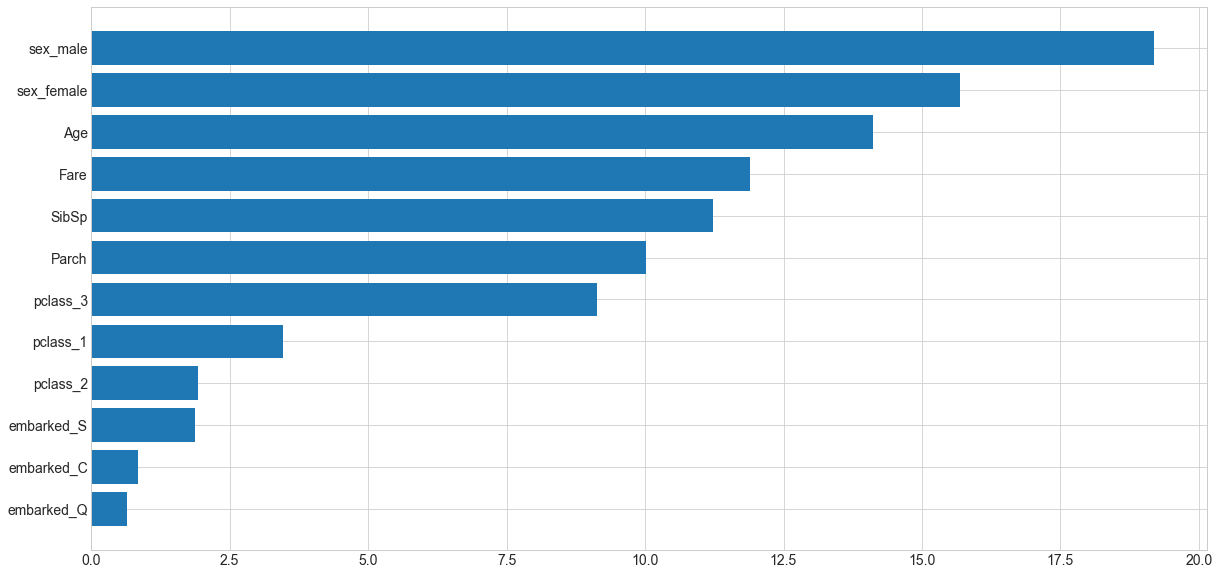

In [169]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)


## Precision and Recall

**Precision:** A metric which measures a model ability to correctly identify only relevent instances

**Recall:** A metric which measures a model ability to find all the relevent cases in a dataset

For example, you may have 100,000 people and only 1 of them gets a certain disease. If your model predicts that all people don't have the disease, it only misses 1 in 100,000 so its accuracy is 99.999%. But this isn't really helpful.

**Recall** would be the models ability to find the 1 person in 100,000 who has the disease and **Precision** would be if the model found the 1 person who had the disease, did they actually have the disease.

In [171]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(data=train_pool,
                                            metrics=metrics,
                                            plot=True)

for metric in metrics:
    print(str(metric)+': {}'.format(np.mean(eval_metrics[metric])))

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.8599226381318651
Recall: 0.7126764705882352
F1: 0.7792873379761954
AUC: 0.9029771563270116


Recall is low, this means there's a higher amount of false negatives (predicting Did not survive when it was actually Survived).

Precision is higher therefore there's less false positives (predicting Survived, when it was actually Did not survive).

## Confusion Matrics for the CatBoostModel

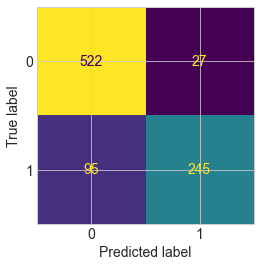

In [176]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(estimator=catboost_model, X=X_train, y_true=y_train, colorbar=False)

Observe in the above confusion matrix there are 95 false negatives (predicting Did not survive when it was actually Survived) resulting Recall to be low and 27 false positives which are less false positives (predicting Survived, when it was actually Did not survive), thus making Precision higher.

## Submission

In [177]:
# We need our test dataframe to look like this
X_train.head()

,Age,SibSp,Parch,Fare,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,35.0,1,0,53.1000,0,0,1,1,0,1,0,0
4,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


In [178]:
# Our test dataframe has some columns our model hasn't been trained on
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [179]:
# One-hot ecode the columns in the test dataframe (like X_train)
test_embarked_one_hot = pd.get_dummies(test.Embarked, prefix='embarked')

test_sex_one_hot = pd.get_dummies(test.Sex, prefix='sex')

test_pclass_one_hot = pd.get_dummies(test.Pclass, prefix='pclass')

In [180]:
# Combine the test one hot encoded columns with test
test = pd.concat([test, test_embarked_one_hot, test_sex_one_hot, test_pclass_one_hot], axis=1)

In [181]:
# Let's look at the test, it should have one-hot encoded columns
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,1,0,0,1,0,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0,0,1,1,0,0,0,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,1,0,0,1,0,1,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,0,1,0,1,0,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0,0,1,1,0,0,0,1


In [182]:
# Create a list of columns to be used for predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'embarked_C', 'embarked_Q',
       'embarked_S', 'sex_female', 'sex_male', 'pclass_1', 'pclass_2',
       'pclass_3'],
      dtype='object')

In [194]:
# Make a predictions using the CatBoost model on the wanted columns
predictions = gs_catboost.predict(test[wanted_test_columns])

In [195]:
predictions[:20]

array([0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1],
      dtype=int64)

In [196]:
# Create a submission dataframe 
submissions = pd.DataFrame()

# Add PassengerID and Survived (predictions) column to the submission dataframe
submissions['PassengerID'] = test['PassengerId']
submissions['Survived'] = predictions # Our model's predictions on the test dataset

In [197]:
submissions.head()

,PassengerID,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [198]:
# What does our submission dataframe have to look like?
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [203]:
# Are our test and submission dataframes of same length?
if len(test) == len(submissions):
    print('True, proceed to save the submission dataframe as csv!!!')
else:
    print('Try agiain!')

True, proceed to save the submission dataframe as csv!!!


In [204]:
# Convert submisison dataframe to csv for submission to csv for Kaggle submisison
submissions.to_csv('catboost_submission.csv', index=False)

In [205]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("catboost_submission.csv")
submissions_check.head()

,PassengerID,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
